In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "-1"

import pickle
from keychest.keychestenv_gofa import features_for_obs
from copy import deepcopy
import pandas as pd
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import gin
from tqdm import tqdm

In [30]:
# loading episodes
fn = 'episodes-1000-config-10x10.gin-2b7cc9d6-fc47-11ea-92c8-a7c627609513.pkl'
fn = 'keychest/' + fn
data = pickle.load(open(fn, 'rb'))

In [31]:
config_fn = fn.split('-')[3]
gin.enter_interactive_mode()
gin.parse_config_file(f"keychest/config/{config_fn}")

In [32]:
def episode_to_time_series(episode):
    """Convert an episode array to a time series dictionary."""
    obs = episode[0]['observation']
    rew = 0.0
    done = False
    
    result = []
    
    def add_to_result(obs, rew, done, initial):
        item = deepcopy(features_for_obs(obs))
        item['reward'] = rew
        item['done'] = done
        item['initial'] = initial
        #item['keys_and_atchest'] = (item['keys_collected'] > 0) and item['at_chest']
        #item['lamp_toggle'] = item['at_button'] ^ item['lamp_state']
        del item['player_position_x']
        del item['player_position_y']
        result.append(item)
        
    add_to_result(obs, 0.0, False, True)
    
    for step in episode[1:]:
        obs, rew, done, info = step['observation'], step['reward'], step['done'], step['info']
        add_to_result(obs, rew, done, False)
        
    return result

In [33]:
# array with episode length
episode_lengths = [len(episode) for episode in data]

In [34]:
# length statistics
np.min(episode_lengths), np.max(episode_lengths)

(16, 91)

In [35]:
# computing features
data_proc = [episode_to_time_series(episode) for episode in data]

In [36]:
print(f"Number of episodes: {len(data)}")

Number of episodes: 999


In [37]:
# all episodes as pandas dataframe
data_proc_df = pd.DataFrame([step for episode in data_proc for step in episode])

In [38]:
data_proc_df[60:]

,lamp_state,at_food,at_key,at_chest,at_button,health,keys_collected,reward,done,initial
60,0,False,False,False,False,33.0,0.0,-0.01,False,False
61,0,False,False,False,False,32.0,0.0,-0.01,False,False
62,0,False,False,False,False,31.0,0.0,-0.01,False,False
63,0,False,False,False,False,30.0,0.0,-0.01,False,False
64,0,False,False,False,False,29.0,0.0,-0.01,False,False
...,...,...,...,...,...,...,...,...,...,...
23299,0,False,False,False,False,4.0,0.0,-0.01,False,False
23300,0,False,False,False,False,3.0,0.0,-0.01,False,False
23301,0,False,False,False,True,2.0,0.0,-0.01,False,False
23302,1,False,False,False,False,1.0,0.0,-0.01,False,False


In [39]:
# sanity checks
for episode in data_proc:
    assert episode[0]['initial'] == True
    assert episode[-1]['done'] == True

In [40]:
## processing data for time series (lag 1)
x_data_proc = [step for episode in data_proc for step in episode[:-1]]
y_data_proc = [step for episode in data_proc for step in episode[1:]]

In [41]:
# converting to a dataframe
x_data_proc_df = pd.DataFrame(x_data_proc)
y_data_proc_df = pd.DataFrame(y_data_proc)

In [42]:
# removing columns which we don't want to predict
do_not_predict = ['at_food', 'at_key', 'at_chest', 'at_button', 'initial']

for col in do_not_predict:
    del y_data_proc_df[col]

In [43]:
x_data_proc_df[356:]

,lamp_state,at_food,at_key,at_chest,at_button,health,keys_collected,reward,done,initial
356,0,False,False,False,False,19.0,1.0,-0.01,False,False
357,0,False,False,False,False,18.0,1.0,-0.01,False,False
358,0,False,False,False,False,17.0,1.0,-0.01,False,False
359,0,False,False,False,False,16.0,1.0,-0.01,False,False
360,0,False,False,False,False,15.0,1.0,-0.01,False,False
...,...,...,...,...,...,...,...,...,...,...
22300,0,False,False,False,False,5.0,0.0,-0.01,False,False
22301,0,False,False,False,False,4.0,0.0,-0.01,False,False
22302,0,False,False,False,False,3.0,0.0,-0.01,False,False
22303,0,False,False,False,True,2.0,0.0,-0.01,False,False


In [44]:
y_data_proc_df[356:]

,lamp_state,health,keys_collected,reward,done
356,0,18.0,1.0,-0.01,False
357,0,17.0,1.0,-0.01,False
358,0,16.0,1.0,-0.01,False
359,0,15.0,1.0,-0.01,False
360,0,14.0,1.0,-0.01,False
...,...,...,...,...,...
22300,0,4.0,0.0,-0.01,False
22301,0,3.0,0.0,-0.01,False
22302,0,2.0,0.0,-0.01,False
22303,1,1.0,0.0,-0.01,False


In [45]:
y_data_proc_df

,lamp_state,health,keys_collected,reward,done
0,0,14.0,0.0,-0.01,False
1,0,13.0,0.0,-0.01,False
2,0,12.0,0.0,-0.01,False
3,0,11.0,0.0,-0.01,False
4,0,10.0,0.0,-0.01,False
...,...,...,...,...,...
22300,0,4.0,0.0,-0.01,False
22301,0,3.0,0.0,-0.01,False
22302,0,2.0,0.0,-0.01,False
22303,1,1.0,0.0,-0.01,False


In [46]:
True & True

True

In [47]:
def predict_manual(features):
    """Predict next features based on current ones."""
    features_new = {}
    
    if features['initial']:
        features_new = {
            'lamp_state': 0,
            'health': gin.query_parameter('keychestenv.KeyChestEnvironment.initial_health') - 1,
            'keys_collected': 0,
            'reward': gin.query_parameter('reward_as_dict.step'),
            'done': False,
        }
    else:
        chest_opened = features['at_chest'] & (features['keys_collected'] > 0)
        
        features_new = {
            'lamp_state': 1 if (features['lamp_state'] == 1) ^ features['at_button'] else 0,
            'health': features['health'] - 1 + features['at_food'] * gin.query_parameter('keychestenv.KeyChestEnvironment.food_efficiency'),
            'keys_collected': features['keys_collected'] - 1. * chest_opened + 1. * features['at_key'],
            'reward': gin.query_parameter('reward_as_dict.step') +\
                features['at_food'] * gin.query_parameter('reward_as_dict.food_collected') +\
                features['at_key'] * gin.query_parameter('reward_as_dict.key_collected') +\
                chest_opened * gin.query_parameter('reward_as_dict.chest_opened'),
            'done': (features['health'] == 1) & (not features['at_food'])
        }
    return features_new

In [48]:
# verifying that there are no prediction mistakes
for (i, row_x), (_, row_y) in tqdm(zip(x_data_proc_df.iterrows(), y_data_proc_df.iterrows()), total=len(x_data_proc_df)):
    row_x = dict(row_x)
    row_y = dict(row_y)
    row_y_pred = predict_manual(dict(row_x))
    assert row_y.keys() == row_y_pred.keys()
    for key in row_y.keys():
        if row_y[key] != row_y_pred[key]:
            print(f"Mismatch at row {i} key {key} true_value {row_y[key]} pred {row_y_pred[key]}")
            print(row_x)
            print(row_y)
            print("")
            
print("Hardcoded model fits the data")

100%|██████████| 22305/22305 [00:07<00:00, 2990.52it/s]

Hardcoded model fits the data


In [49]:
to_add = {}
for _, row in x_data_proc_df.iterrows():
    additional = {}
    
    additional['done_predictor'] = (row['health'] == 1) & (not row['at_food'])
    additional['chest_opened'] = row['at_chest'] & (row['keys_collected'] > 0)
    additional['lamp_on_xor_button'] = (row['lamp_state'] == 1) ^ row['at_button']
    
    for key, value in additional.items():
        if key not in to_add:
            to_add[key] = []
        to_add[key].append(value)

In [50]:
for key, value in to_add.items():
    x_data_proc_df[key] = value

In [51]:
X = np.array(x_data_proc_df, dtype=np.float32)
y = np.array(y_data_proc_df, dtype=np.float32)

In [52]:
X.shape, y.shape

((22305, 13), (22305, 5))

In [53]:
# creating a linear model
model = tf.keras.Sequential([
    tf.keras.Input(X.shape[1]),
    tf.keras.layers.Dense(y.shape[1], activation=None, use_bias=True)])
model.compile('adam', 'mae')
losses = []

In [73]:
epochs = 1000
with tqdm(total=epochs) as pbar:
    for step in range(epochs):
        h = model.fit(X, y, verbose=0, epochs=1, batch_size=1000)
        losses.append(h.history['loss'][0])
        pbar.update(1)

100%|██████████| 100/100 [00:04<00:00, 23.26it/s]


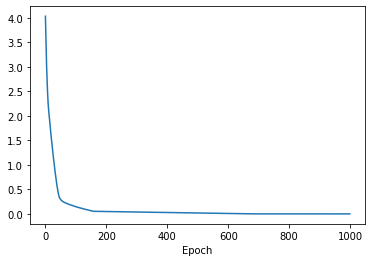

Minimal loss 0.0013337567215785384
Epochs 1000


In [74]:
plt.plot(losses)
plt.xlabel('Epoch')
plt.show()
print("Minimal loss", losses[-1])
print("Epochs", len(losses))

In [90]:
# get causal graph from the model
G = pd.DataFrame(np.concatenate((model.get_weights()[0], model.get_weights()[1].reshape(1, -1)), axis=0).T)
G.columns = list(x_data_proc_df.columns) + ["bias"]
G.index = y_data_proc_df.columns
cmap = sns.diverging_palette(20, 220, as_cmap=True)

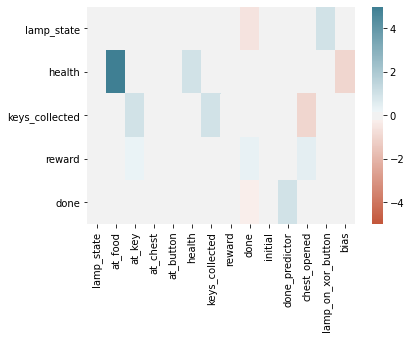

In [91]:
# show the causal model
sns.heatmap(G, cmap=cmap, vmin=-5, vmax=5)